# Bibliotecas e Ambiente

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier,
)
from capymoa.drift.detectors import ADWIN
from sklearn.metrics import accuracy_score, precision_score, f1_score
from collections import Counter
from py.functions import criar_stream


# Desenvolvimento

## Stream

In [3]:
FILE = r'datasets\CICDDoS2019\data\Benign_Portmap_NetBIOS.csv'
# FILE = r'datasets\CICDDoS2019\data\Benign_DNS.csv'
# FILE = r'datasets\CICDDoS2019\data\Benign_DNS_LDAP.csv'
df_raw = pd.read_csv(FILE, low_memory=False)

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
stream, le_global, features_finais = criar_stream(
    df=df_raw
)

# # --- Verificações e Logs ---
print("-" * 40)
print(f"Processamento Concluído.")
print(f"Features Originais no CSV: {len(df_raw.columns)}")
print(f"Features Mantidas: {len(features_finais)}")
print("-" * 40)
print("Schema da Stream (CapyMOA):")
print(stream.get_schema())

Features redundantes removidas: 23
----------------------------------------
Processamento Concluído.
Features Originais no CSV: 88
Features Mantidas: 44
----------------------------------------
Schema da Stream (CapyMOA):
@relation No_Name

@attribute Protocol numeric
@attribute 'Flow Duration' numeric
@attribute 'Total Fwd Packets' numeric
@attribute 'Total Length of Fwd Packets' numeric
@attribute 'Fwd Packet Length Max' numeric
@attribute 'Fwd Packet Length Min' numeric
@attribute 'Fwd Packet Length Mean' numeric
@attribute 'Fwd Packet Length Std' numeric
@attribute 'Bwd Packet Length Max' numeric
@attribute 'Bwd Packet Length Min' numeric
@attribute 'Bwd Packet Length Mean' numeric
@attribute 'Flow Bytes/s' numeric
@attribute 'Flow IAT Mean' numeric
@attribute 'Flow IAT Std' numeric
@attribute 'Flow IAT Max' numeric
@attribute 'Flow IAT Min' numeric
@attribute 'Fwd IAT Mean' numeric
@attribute 'Bwd IAT Total' numeric
@attribute 'Bwd IAT Mean' numeric
@attribute 'Bwd IAT Std' numeri

## Modelos

In [4]:
models_state = [
    {
        "name": "LeveragingBagging",
        "model": LeveragingBagging(
            schema=stream.schema,
            CLI=None,
            random_seed=1,
            base_learner=None,
            ensemble_size=100,
            minibatch_size=None,
            number_of_jobs=None
        ),
        "adwin": ADWIN(delta=0.002),
        "drifts_detected": [],
        "window_errors": [],
        "accuracy_history": [],
        "confusion_matrix": {}, 
        "total_instances": 0
    },
    {
        "name": "HoeffdingAdaptiveTree",
        "model": HoeffdingAdaptiveTree(
            schema=stream.schema,
            random_seed=0,
            grace_period=200,
            split_criterion='InfoGainSplitCriterion',
            confidence=0.01,
            tie_threshold=0.05,
            leaf_prediction='NaiveBayesAdaptive',
            nb_threshold=0,
            numeric_attribute_observer='GaussianNumericAttributeClassObserver',
            binary_split=False,
            max_byte_size=33554432,
            memory_estimate_period=1000000,
            stop_mem_management=True,
            remove_poor_attrs=False,
            disable_prepruning=True
        ),
        "adwin": ADWIN(delta=0.002),
        "drifts_detected": [],
        "window_errors": [],
        "accuracy_history": [],
        "confusion_matrix": {},
        "total_instances": 0
    },
    {
        "name": "AdaptiveRandomForest",
        "model": AdaptiveRandomForestClassifier(
            schema=stream.schema,
            CLI=None,
            random_seed=1,
            base_learner=None,
            ensemble_size=100,
            max_features=0.6,
            lambda_param=6.0,
            minibatch_size=None,
            number_of_jobs=1,
            drift_detection_method=None,
            warning_detection_method=None,
            disable_weighted_vote=False,
            disable_drift_detection=False,
            disable_background_learner=False
        ),
        "adwin": ADWIN(delta=0.002),
        "drifts_detected": [],
        "window_errors": [],
        "accuracy_history": [],
        "confusion_matrix": {},
        "total_instances": 0
    },
    {
        "name": "HoeffdingTree",
        "model": HoeffdingTree(
            schema=stream.schema,
            random_seed=1
        ),
        "adwin": ADWIN(delta=0.002),
        "drifts_detected": [],
        "window_errors": [],
        "accuracy_history": [],
        "confusion_matrix": {},
        "total_instances": 0
    }
]

## Treinamento

In [5]:
MAX_INSTANCES = len(df_raw)
WINDOW_SIZE = 250 

# Mapeamento de Classes 
classes_map = {i: label for i, label in enumerate(le_global.classes_)}
NORMAL_LABEL_ID = le_global.transform(['BENIGN'])[0] if 'BENIGN' in le_global.classes_ else 0

instance_count_history = []
count = 0
stream.restart()

# REINICIALIZAÇÃO COMPLETA DOS ESTADOS 
for state in models_state:
    state["accuracy_history"] = []
    state["f1_history"] = []
    state["precision_history"] = []
    state["drifts_detected"] = []
    state["confusion_matrix"] = {} 
    state["total_instances"] = 0
    state["window_buffer_true"] = []
    state["window_buffer_pred"] = []
    state["window_class_counts"] = Counter()
    state["detected_attacks_history"] = []
    state["adwin"] = ADWIN() 


while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for state in models_state:
        model = state["model"]
        adwin = state["adwin"]
        
        # Predict 
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        except (IndexError, TypeError):
            prediction_value = prediction
            
        y_true = instance.y_index
        y_pred = prediction_value
        
        state["window_class_counts"][y_pred] += 1
        
        # Atualização Matriz Confusão 
        if y_true not in state["confusion_matrix"]:
            state["confusion_matrix"][y_true] = {}
        if y_pred not in state["confusion_matrix"][y_true]:
            state["confusion_matrix"][y_true][y_pred] = 0
        state["confusion_matrix"][y_true][y_pred] += 1
        state["total_instances"] += 1
        
        # Drift Detection 
        error = 0.0 if y_pred == y_true else 1.0 
        
        # Adiciona o elemento
        adwin.add_element(error)
        
        # Verifica mudança 
        if adwin.detected_change():
            state["drifts_detected"].append(count)
            
        #  Buffers e Treino 
        state["window_buffer_true"].append(y_true)
        state["window_buffer_pred"].append(y_pred)
        model.train(instance)
        
        # FECHAMENTO DA JANELA 
        if is_window_boundary:
            y_w_true = state["window_buffer_true"]
            y_w_pred = state["window_buffer_pred"]
            
            # Métricas
            acc_val = accuracy_score(y_w_true, y_w_pred) * 100
            f1_val = f1_score(y_w_true, y_w_pred, average='macro', zero_division=0)
            prec_val = precision_score(y_w_true, y_w_pred, average='macro', zero_division=0)
            
            state["accuracy_history"].append(acc_val)
            state["f1_history"].append(f1_val)
            state["precision_history"].append(prec_val)
            
            # Identificação de Ataques
            attack_counts = state["window_class_counts"].copy()
            if NORMAL_LABEL_ID in attack_counts:
                del attack_counts[NORMAL_LABEL_ID]
            
            if attack_counts:
                most_common_attack_id, freq = attack_counts.most_common(1)[0]
                attack_name = classes_map[most_common_attack_id]
                state["detected_attacks_history"].append((count, attack_name, freq))
            else:
                state["detected_attacks_history"].append((count, "None", 0))

            state["window_buffer_true"] = []
            state["window_buffer_pred"] = []
            state["window_class_counts"] = Counter()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

## Resultados

In [15]:
# Função auxiliar para encontrar o índice da janela mais próxima de uma instância
def find_nearest_window_index(instance_num, history_x):
    for i, val in enumerate(history_x):
        if val >= instance_num:
            return i
    return len(history_x) - 1

for state in models_state:
    # Lógica da Matriz de Confusão 
    cm = state["confusion_matrix"]
    total_instances = state["total_instances"] # Necessário para cálculo de VN
    
    all_classes = set(cm.keys())
    for true_cls in cm:
        all_classes.update(cm[true_cls].keys())
    
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    valid_classes = 0
    total_vp = 0 
    
    print(f"\n{'='*30}")
    print(f"MODELO: {state['name']}")
    print(f"{'='*30}")
    
    # Tabela Detalhada por Classe (VP, FN, FP, VN)
    header = f"  {'Classe':<20} | {'VP':<6} | {'FN':<6} | {'FP':<6} | {'VN':<6} | {'Recall':<8} | {'Precis.':<8}"
    print(header)
    print(f"  {'-'*len(header)}")

    # Cálculo das métricas por classe e Globais
    for cls in sorted(all_classes):
        # VP: Era CLS e previu CLS
        vp = cm.get(cls, {}).get(cls, 0)
        
        # FN: Era CLS, mas previu OUTRA coisa 
        fn = sum(cm.get(cls, {}).get(other, 0) for other in all_classes if other != cls)
        
        # FP: Era OUTRA coisa, mas previu CLS 
        fp = sum(cm.get(other, {}).get(cls, 0) for other in all_classes if other != cls)
        
        # VN: Não era CLS e previu qualquer coisa que NÃO seja CLS
        # VN = Total - (VP + FN + FP)
        vn = total_instances - (vp + fn + fp)

        total_vp += vp # Para acurácia global

        # Métricas
        precision = vp / (vp + fp) if (vp + fp) > 0 else 0.0
        recall = vp / (vp + fn) if (vp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        macro_precision += precision
        macro_recall += recall
        macro_f1 += f1
        valid_classes += 1
        
        # Print da linha da tabela
        print(f"  {str(cls):<20} | {vp:<6} | {fn:<6} | {fp:<6} | {vn:<6} | {recall:.4f}   | {precision:.4f}")
    print(f"  {'-'*len(header)}")

    if valid_classes > 0:
        final_precision = macro_precision / valid_classes
        final_recall = macro_recall / valid_classes
        final_f1 = macro_f1 / valid_classes
    else:
        final_precision = final_recall = final_f1 = 0.0
        
    final_accuracy = total_vp / state["total_instances"]
    
    # Exibição Global
    print(f"  Acurácia Global:     {final_accuracy:.4f}")
    print(f"  F1-Score (Macro):   {final_f1:.4f}")
    
    # Análise Detalhada dos Drifts 
    drifts = state['drifts_detected']
    acc_hist = state['accuracy_history']
    x_hist = instance_count_history 
    
    if len(drifts) > 0:
        print(f"\n  HISTÓRICO DE DRIFTS")
        print(f"  {'Amostra #':<12} | {'Queda Acurácia':<20} | {'Recuperação':<25}")
        print(f"  {'-'*12}-+-{'-'*20}-+-{'-'*25}")
        
        for drift_idx in drifts:
            # Identifica em qual janela o drift foi registrado visualmente
            idx_window = find_nearest_window_index(drift_idx, x_hist)
            
            # Precisamos da janela anterior para saber quanto caiu
            if idx_window > 0 and idx_window < len(acc_hist):
                acc_before = acc_hist[idx_window - 1]
                acc_after = acc_hist[idx_window]
                drop = acc_before - acc_after
                
                # Formatação visual da queda
                drop_str = f"{acc_before:.1f}% -> {acc_after:.1f}%"
                diff_str = f"(-{drop:.1f}%)" if drop > 0 else f"(+{abs(drop):.1f}%)"
                col_drop = f"{drop_str} {diff_str}"
                
                # Calcular tempo de recuperação
                # Procura no futuro quando a acurácia volta a ser >= acc_before
                recovery_samples = "Não recuperou"
                for k in range(idx_window + 1, len(acc_hist)):
                    if acc_hist[k] >= acc_before:
                        samples_passed = x_hist[k] - drift_idx
                        recovery_samples = f"{samples_passed} amostras"
                        break
            else:
                col_drop = "Sem dados anteriores"
                recovery_samples = "-"

            print(f"  {drift_idx:<12} | {col_drop:<20} | {recovery_samples:<25}")
            
    else:
        print("\n  Nenhum drift detectado para análise detalhada.")
    print("\n")


MODELO: LeveragingBagging
  Classe               | VP     | FN     | FP     | VN     | Recall   | Precis. 
  --------------------------------------------------------------------------------
  0                    | 61651  | 30     | 94     | 25190  | 0.9995   | 0.9985
  1                    | 14984  | 15     | 0      | 71966  | 0.9990   | 1.0000
  2                    | 10199  | 86     | 37     | 76643  | 0.9916   | 0.9964
  --------------------------------------------------------------------------------
  Acurácia Global:     0.9985
  F1-Score (Macro):   0.9975

  HISTÓRICO DE DRIFTS
  Amostra #    | Queda Acurácia       | Recuperação              
  -------------+----------------------+--------------------------
  15071        | 100.0% -> 94.0% (-6.0%) | 5429 amostras            



MODELO: HoeffdingAdaptiveTree
  Classe               | VP     | FN     | FP     | VN     | Recall   | Precis. 
  --------------------------------------------------------------------------------
  0      

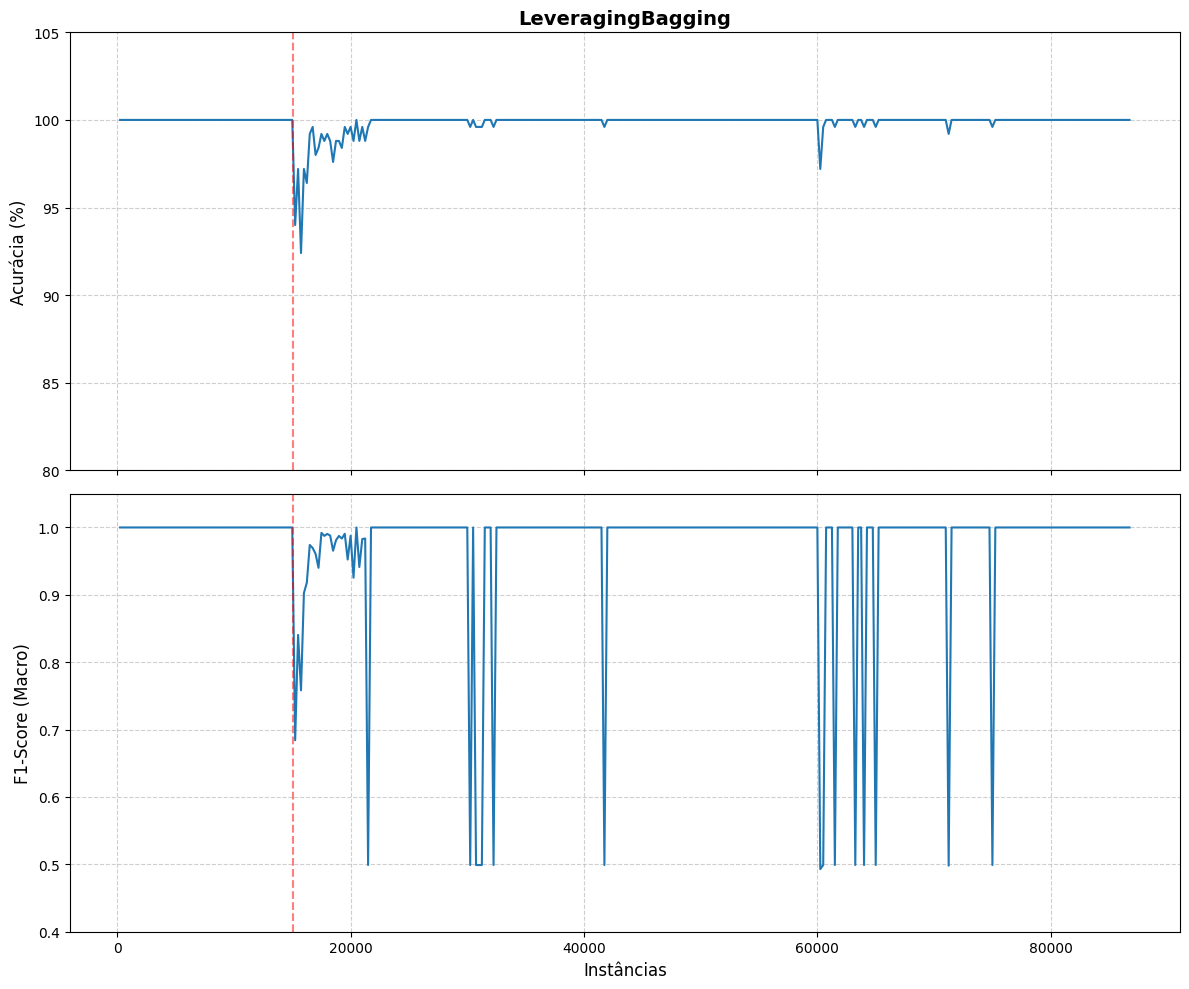

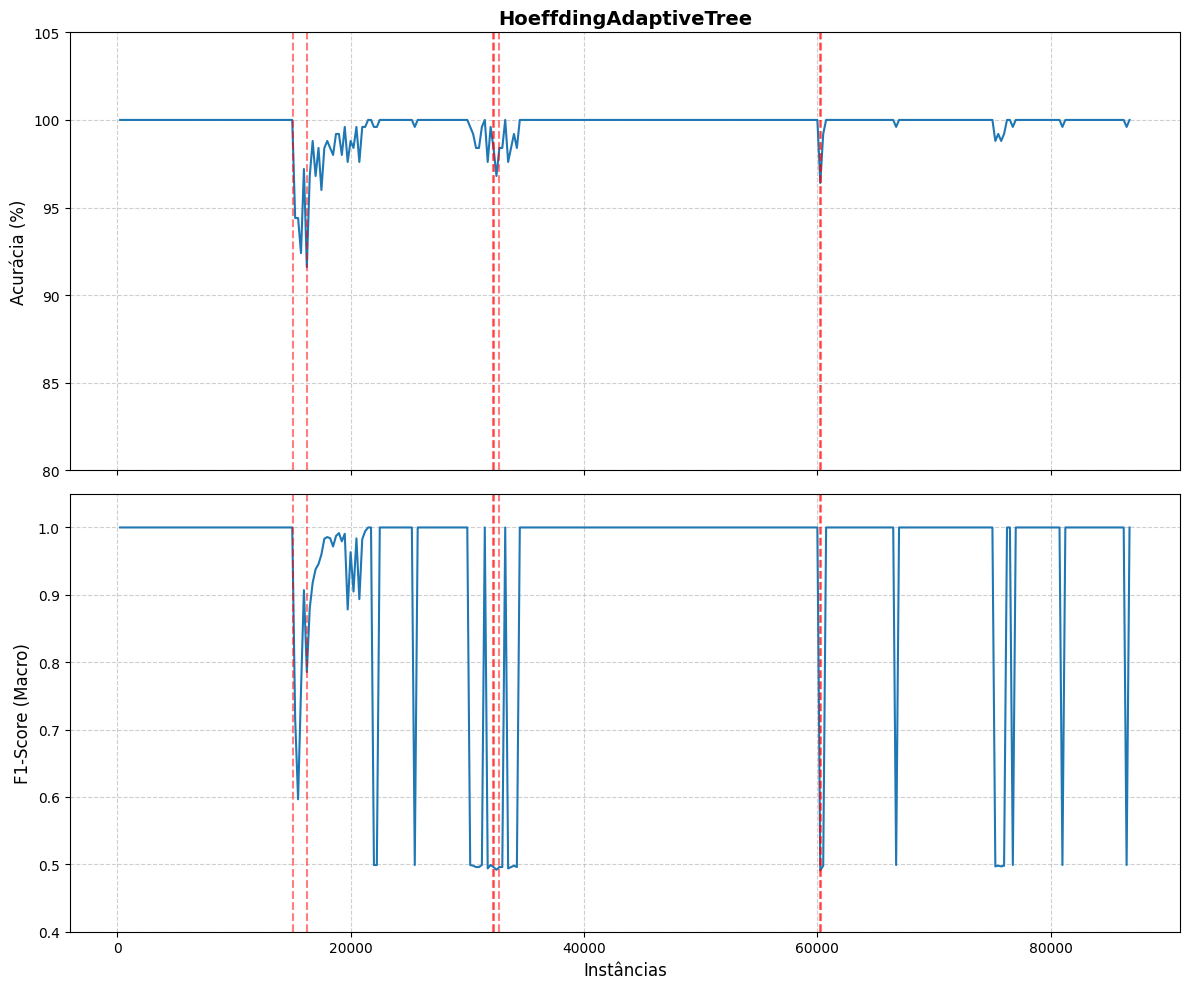

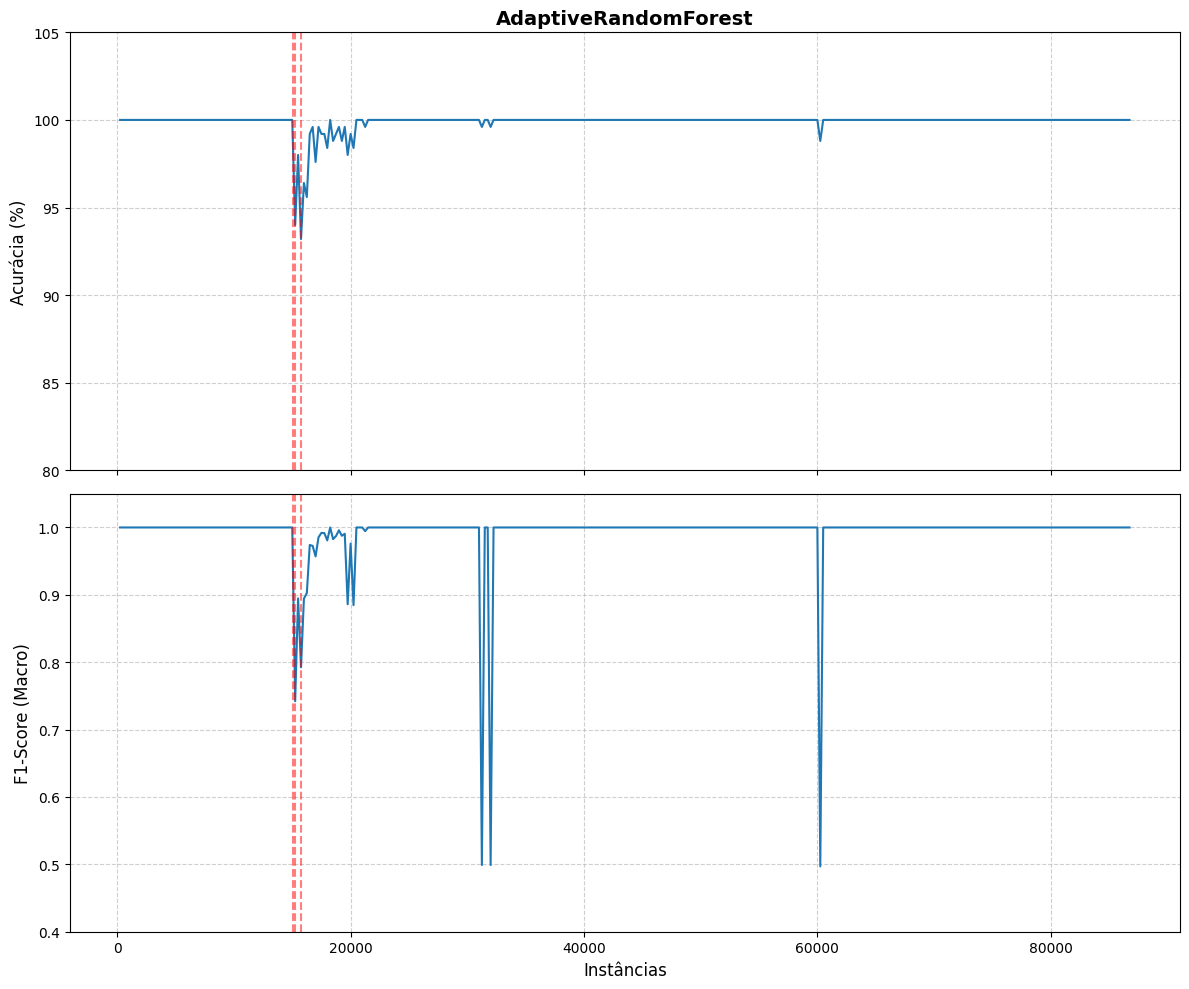

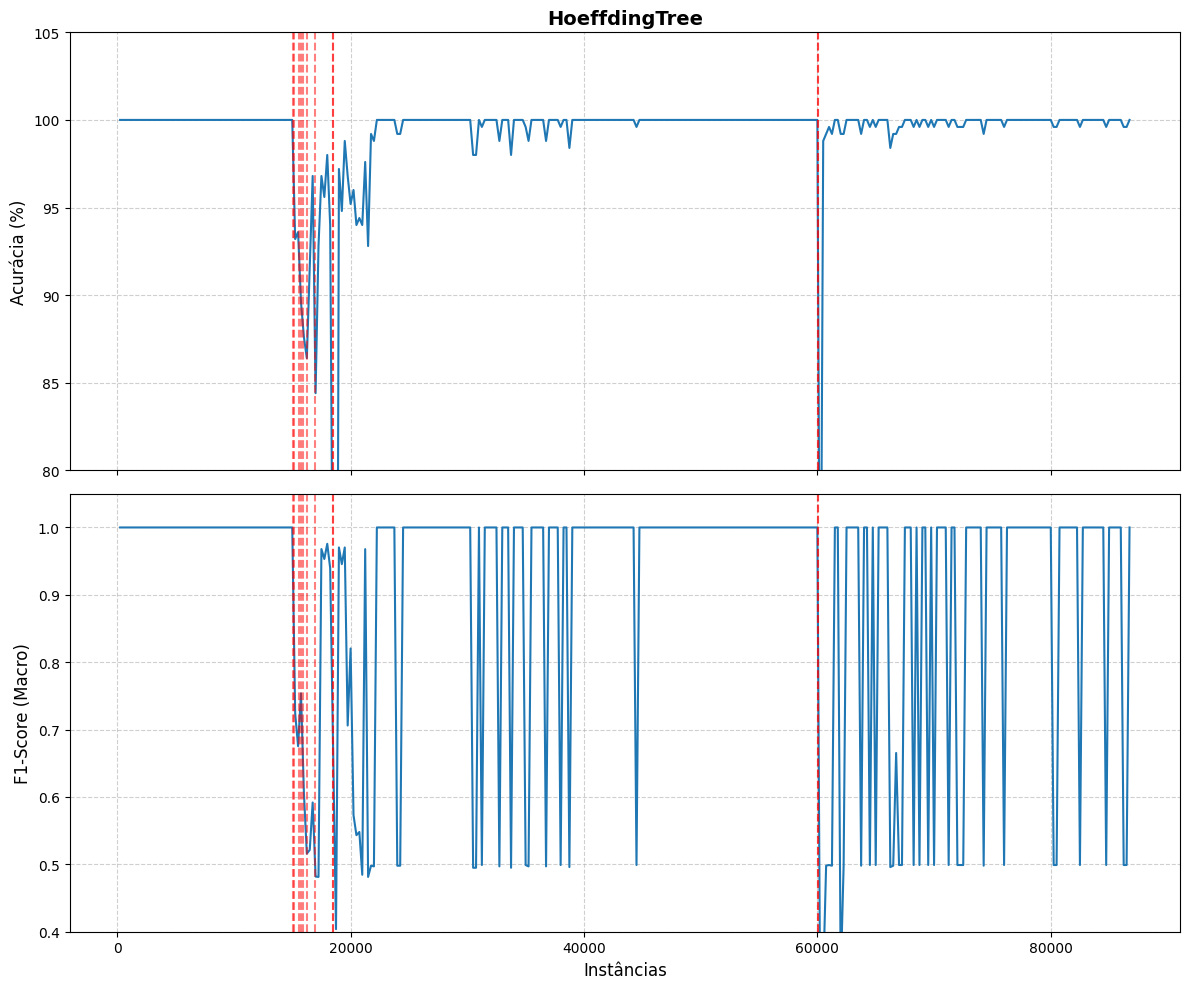

In [20]:
for state in models_state:
    # Cria uma NOVA figura para CADA modelo
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    c = 'tab:blue' 
    
    # Garante alinhamento dos eixos X e Y
    limit = min(len(instance_count_history), len(state['accuracy_history']))
    x_axis = instance_count_history[:limit]
    
    # Acurácia 
    ax1.plot(x_axis, state['accuracy_history'][:limit], label='Acurácia', color=c, markersize=4)
    ax1.set_ylabel('Acurácia (%)', fontsize=12)
    ax1.set_title(state['name'], fontsize=14, fontweight='bold') 
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(80, 105)
    
    # F1-Score 
    ax2.plot(x_axis, state['f1_history'][:limit], label='F1-Score', color=c, markersize=4)
    ax2.set_ylabel('F1-Score (Macro)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylim(0.4, 1.05)
    ax2.set_xlabel('Instâncias', fontsize=12)

    
    # Adicionar Linhas de Drift
    drift_count = len(state['drifts_detected'])
    if drift_count > 0:
        for drift_x in state['drifts_detected']:
            # Mantive vermelho para destacar o evento, mas sem legenda
            ax1.axvline(x=drift_x, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
            ax2.axvline(x=drift_x, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    plt.tight_layout()
    plt.show()